In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

In [2]:
import arviz as az
import numpy as np
import pandas as pd

import causalpy as cp

# ITS - refactored code

In [ ]:
df = (
    cp.load_data("its")
    .assign(date=lambda x: pd.to_datetime(x["date"]))
    .set_index("date")
)

treatment_time = pd.to_datetime("2017-01-01")
df.head()

## Bayesian

In [ ]:
pymc_result = cp.InterruptedTimeSeries(
    df,
    treatment_time,
    formula="y ~ 1 + t + C(month)",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)

In [ ]:
pymc_result.summary()

In [ ]:
pymc_result.print_coefficients()

In [ ]:
pymc_result.plot()

## OLS

In [ ]:
ols_result = cp.InterruptedTimeSeries(
    df,
    treatment_time,
    formula="y ~ 1 + t + C(month)",
    model=cp.skl_models.LinearRegression(),
)

In [ ]:
ols_result.summary()

In [ ]:
ols_result.print_coefficients()

In [ ]:
ols_result.plot()

# SC - refactored code

In [ ]:
df = cp.load_data("sc")
treatment_time = 70

In [ ]:
pymc_result = cp.SyntheticControl(
    df,
    treatment_time,
    formula="actual ~ 0 + a + b + c + d + e + f + g",
    model=cp.pymc_models.WeightedSumFitter(
        sample_kwargs={"target_accept": 0.95, "random_seed": seed}
    ),
)

In [ ]:
pymc_result.summary()

In [ ]:
pymc_result.print_coefficients()

In [ ]:
pymc_result.plot()

## OLS

In [ ]:
# Note, we do not want an intercept in this model
ols_result = cp.SyntheticControl(
    df,
    treatment_time,
    formula="actual ~ 0 + a + b + c + d + e + f + g",
    model=cp.skl_models.WeightedProportion(),
)

In [ ]:
ols_result.summary()

In [ ]:
ols_result.print_coefficients()

In [ ]:
ols_result.plot()

# DiD - refactored code

In [24]:
df = cp.load_data("did")

In [25]:
result = cp.DifferenceInDifferences(
    df,
    formula="y ~ 1 + group*post_treatment",
    time_variable_name="t",
    group_variable_name="group",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


In [26]:
# result.causal_impact
from causalpy.utils import convert_to_string

convert_to_string(result.causal_impact, round_to=2)

'0.50$CI_{94\\%}$[0.4, 0.6]'

In [27]:
result.summary()

===========================Difference in Differences============================
Formula: y ~ 1 + group*post_treatment

Results:
Causal impact = 0.50$CI_{94\%}$[0.4, 0.6]
Model coefficients:
    Intercept                     1.1, 94% HDI [1, 1.1]
    post_treatment[T.True]        0.99, 94% HDI [0.92, 1.1]
    group                         0.16, 94% HDI [0.094, 0.23]
    group:post_treatment[T.True]  0.5, 94% HDI [0.4, 0.6]
    sigma                         0.082, 94% HDI [0.066, 0.1]


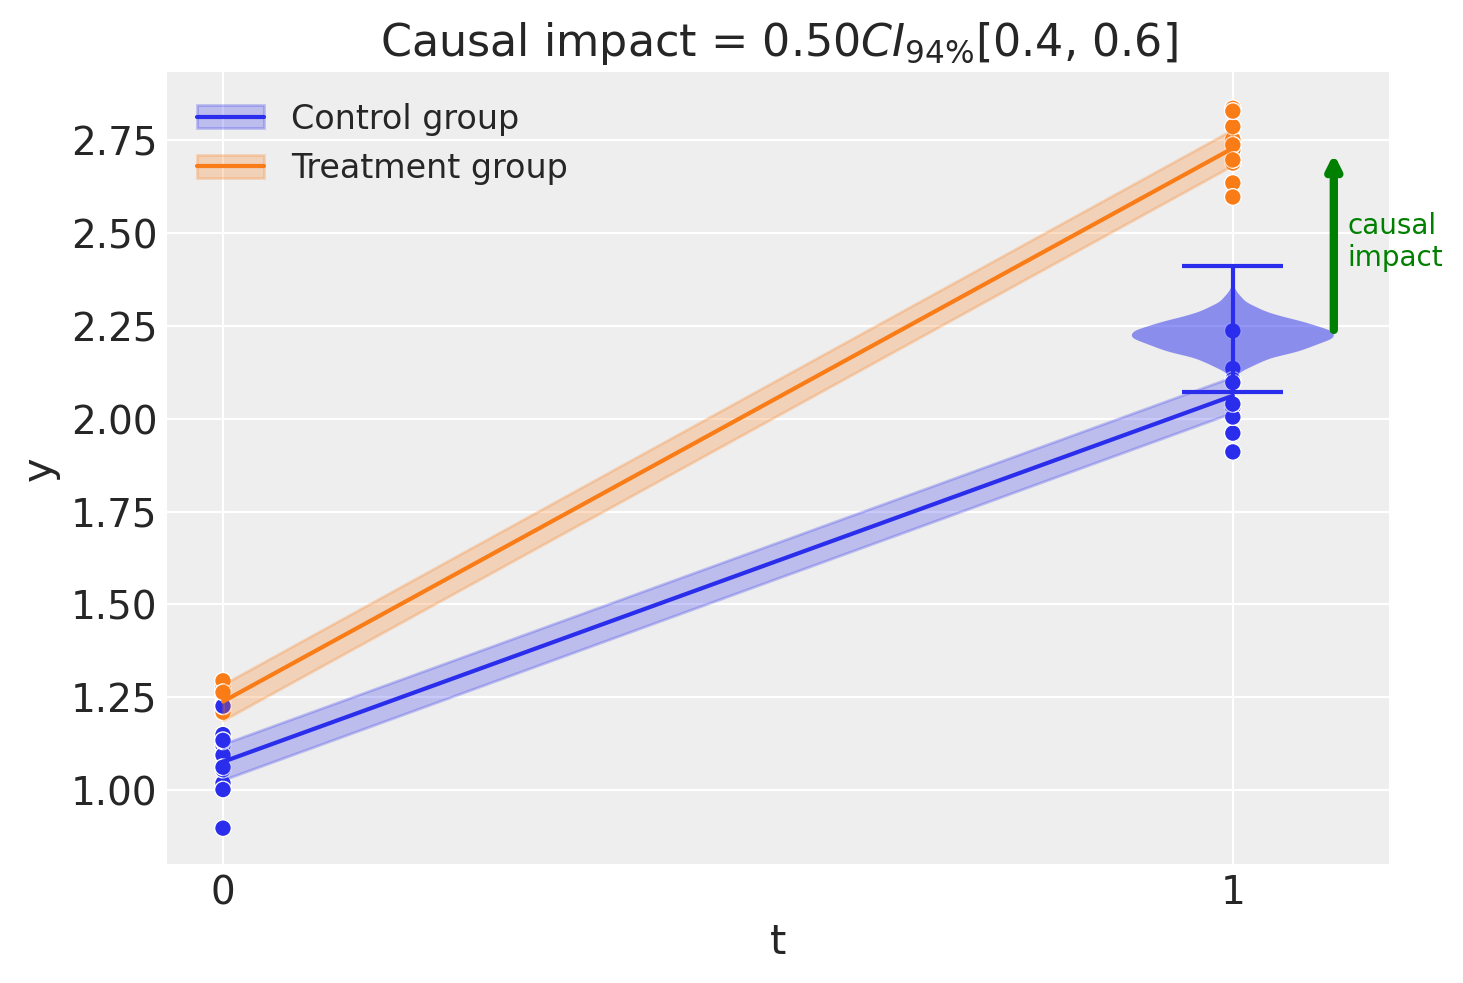

In [28]:
result.plot();

In [33]:
result = cp.DifferenceInDifferences(
    df,
    formula="y ~ 1 + group*post_treatment",
    time_variable_name="t",
    group_variable_name="group",
    treated=1,
    untreated=0,
    model=cp.skl_models.LinearRegression(),
)

In [35]:
result.summary()

===========================Difference in Differences============================
Formula: y ~ 1 + group*post_treatment

Results:
Causal impact = 0.50
Model coefficients:
  Intercept                   	         0
  post_treatment[T.True]      	      0.99
  group                       	      0.16
  group:post_treatment[T.True]	       0.5


In [ ]:
result.print_coefficients()

In [ ]:
result.plot()

## ANOVA - Pre/Post NEGD

In [ ]:
df = cp.load_data("anova1")

In [ ]:
result = cp.PrePostNEGD(
    df,
    formula="post ~ 1 + C(group) + pre",
    group_variable_name="group",
    pretreatment_variable_name="pre",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
)

In [ ]:
result.summary()

In [ ]:
result.print_coefficients()

In [ ]:
result.plot()

# Regression discontinuity

In [ ]:
df = cp.load_data("rd")

### Bayesian

In [ ]:
result = cp.RegressionDiscontinuity(
    df,
    formula="y ~ 1 + x + treated + x:treated",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    treatment_threshold=0.5,
)

In [ ]:
result.discontinuity_at_threshold

In [ ]:
from causalpy.utils import convert_to_string

convert_to_string(result.discontinuity_at_threshold)

In [ ]:
result.summary()

In [ ]:
result.print_coefficients()

In [ ]:
result.plot()

### OLS

In [ ]:
result = cp.RegressionDiscontinuity(
    df,
    formula="y ~ 1 + x + treated + x:treated",
    model=cp.skl_models.LinearRegression(),
    treatment_threshold=0.5,
)

In [ ]:
result.summary()

In [ ]:
result.print_coefficients()

In [ ]:
result.plot()

# Regression Kink

In [ ]:
seed = 42
rng = np.random.default_rng(seed)


def f(x, beta, kink):
    return (
        beta[0]
        + beta[1] * x
        + beta[2] * x**2
        + beta[3] * (x - kink) * (x >= kink)
        + beta[4] * (x - kink) ** 2 * (x >= kink)
    )


def generate_data(beta, kink, sigma=0.05, N=50):
    if beta is None:
        beta = rng.random(5)
    x = rng.uniform(-1, 1, N)
    y = f(x, beta, kink) + rng.normal(0, sigma, N)
    df = pd.DataFrame({"x": x, "y": y, "treated": x >= kink})
    return df


kink = 0.5
# linear function with gradient change of 2 at kink point
beta = [0, -1, 0, 2, 0]
sigma = 0.05
df = generate_data(beta, kink, sigma=sigma)

In [ ]:
result = cp.RegressionKink(
    df,
    formula=f"y ~ 1 + x + I((x-{kink})*treated)",
    model=cp.pymc_models.LinearRegression(sample_kwargs={"random_seed": seed}),
    kink_point=kink,
    epsilon=0.1,
)

In [ ]:
result.summary()

In [ ]:
result.plot()

# Instrumental Variables

In [ ]:
N = 100
e1 = np.random.normal(0, 3, N)
e2 = np.random.normal(0, 1, N)
Z = np.random.uniform(0, 1, N)
## Ensure the endogeneity of the the treatment variable
X = -1 + 4 * Z + e2 + 2 * e1
y = 2 + 3 * X + 3 * e1

test_data = pd.DataFrame({"y": y, "X": X, "Z": Z})

In [ ]:
sample_kwargs = {
    "tune": 1000,
    "draws": 2000,
    "chains": 4,
    "cores": 4,
    "target_accept": 0.99,
}
instruments_formula = "X  ~ 1 + Z"
formula = "y ~  1 + X"
instruments_data = test_data[["X", "Z"]]
data = test_data[["y", "X"]]
iv = cp.InstrumentalVariable(
    instruments_data=instruments_data,
    data=data,
    instruments_formula=instruments_formula,
    formula=formula,
    model=cp.pymc_models.InstrumentalVariableRegression(sample_kwargs=sample_kwargs),
)

# Inverse propensity score weighting

In [ ]:
df1 = pd.DataFrame(
    np.random.multivariate_normal([0.5, 1], [[2, 1], [1, 1]], size=10000),
    columns=["x1", "x2"],
)
df1["trt"] = np.where(
    -0.5 + 0.25 * df1["x1"] + 0.75 * df1["x2"] + np.random.normal(0, 1, size=10000) > 0,
    1,
    0,
)
TREATMENT_EFFECT = 2
df1["outcome"] = (
    TREATMENT_EFFECT * df1["trt"]
    + df1["x1"]
    + df1["x2"]
    + np.random.normal(0, 1, size=10000)
)

In [ ]:
seed = 42
result = cp.InversePropensityWeighting(
    df1,
    formula="trt ~ 1 + x1 + x2",
    outcome_variable="outcome",
    weighting_scheme="robust",
    model=cp.pymc_models.PropensityScore(
        sample_kwargs={
            "draws": 1000,
            "target_accept": 0.95,
            "random_seed": seed,
            "progressbar": False,
        },
    ),
)

In [ ]:
az.plot_posterior(result.model.idata, var_names=["b"]);

In [ ]:
result.plot_balance_ecdf("x1", weighting_scheme="raw");